In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

### Let's start by simulating some data from a known function, $f=\mathrm{sin}(x/2)$

### We'll assume no noise for now.


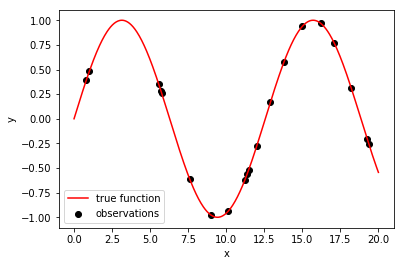

In [55]:
# First plot the function
xspace = np.linspace(0, 20, 500)
f = np.sin(xspace / 2) 
plt.plot(xspace, f, color='red', label='true function')

# sample some random locations x
N = 20
x = np.random.uniform(low=0, high=20, size=N)
# and, sample some observations
y = np.sin(x / 2)
plt.scatter(x, y, color='black', label='observations')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## We're going to use a Gaussian process to approximate this

A Gaussian process is defined in terms of its covariance function. We can choose any kernel function for this. A common choice is the squared exponential:

$$k(x, x') = \alpha^2 \exp\left\{-\frac{1}{2\ell^2}(x-x')^2\right\}$$

The code below constructs a kernel function, and plots a sample with $\alpha=1$, $\ell=1$

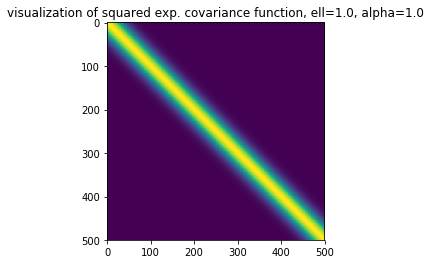

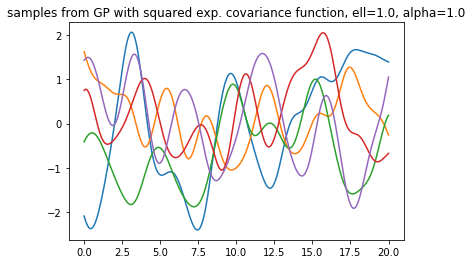

In [57]:
def squared_exponential_kernel(x1, x2, ell=1., alpha=1.):
    dx = np.expand_dims(x1, 1) - np.expand_dims(x2, 0)
    return (alpha ** 2) * np.exp(-((dx / ell) ** 2) / 2)


def plot_samples(xvals, 
                 num_samples, 
                 kernel_function=squared_exponential_kernel, 
                 kernel_args = {'ell': 1., 'alpha': 1.},
                 mean_function = None
                ):
    K = kernel_function(xvals, xvals, **kernel_args)
    for i in range(num_samples):
        yvals = np.random.multivariate_normal(mean=np.zeros(xvals.shape), cov=K)
        plt.plot(xvals,yvals)
        
## Let's first look at what the kernel looks like

ell=1.
alpha=1.
xs = np.linspace(0, 20, 500)
K_se = squared_exponential_kernel(xs, xs, ell=ell, alpha=alpha)

plt.imshow(K_se)
plt.title('visualization of squared exp. covariance function, ell={}, alpha={}'.format(ell, alpha))
plt.show()

## Now let's plot some samples
num_samples = 5
plot_samples(xs, num_samples, kernel_function=squared_exponential_kernel, kernel_args={'ell': ell, 'alpha': alpha})
plt.title('samples from GP with squared exp. covariance function, ell={}, alpha={}'.format(ell, alpha))
plt.show()

## Explore some different values of $\ell$ and $\alpha$. What effect do they have on the function? 

$\ell$ is often referred to as the lengthscale. Why is this?

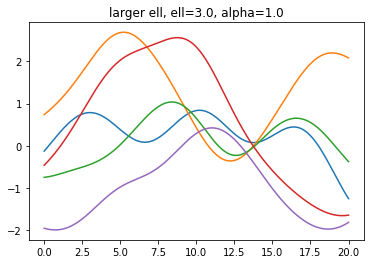

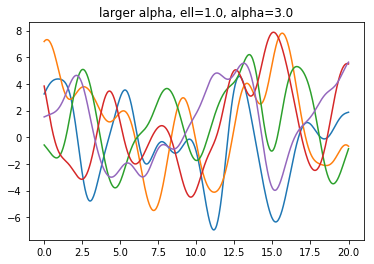

In [58]:
ell_large = 3.
plot_samples(xs, num_samples, kernel_function=squared_exponential_kernel, 
             kernel_args={'ell': ell_large, 'alpha': alpha})
plt.title('larger ell, ell={}, alpha={}'.format(ell_large, alpha))
plt.show()

alpha_large = 3.
plot_samples(xs, num_samples, kernel_function=squared_exponential_kernel, 
             kernel_args={'ell': ell, 'alpha': alpha_large})
plt.title('larger alpha, ell={}, alpha={}'.format(ell, alpha_large))
plt.show()




## Increasing $\ell$ makes the function smoother - it determines the lengthscale of the variation

## Increasing $\alpha$ increases the amplitude

## Let's also look at a different kernel. 

Below, implement

$k_a(x,x') = \exp\left\{-\frac{2\sin^2\left(\frac{x-x'}{2}\right)}{\ell^2}\right\}$

and plot for a few values of $\ell$. What sort of data might this be appropriate for?

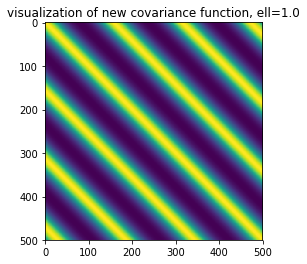

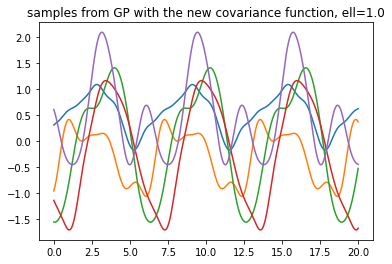

In [71]:
def new_kernel(x1, x2, ell=1.):
    dx = np.expand_dims(x1, 1) - np.expand_dims(x2, 0)
   
    return np.exp(-2 * (np.sin(dx / 2) ** 2) / (ell ** 2))
    
ell = 1.
K_new = new_kernel(xs, xs, ell=ell)

plt.imshow(K_new)
plt.title('visualization of new covariance function, ell={}'.format(ell))
plt.show()

plot_samples(xs, num_samples, kernel_function=new_kernel, kernel_args={'ell': ell})

plt.title('samples from GP with the new covariance function, ell={}'.format(ell))
plt.show()

## Appropriate for periodic data!!

### We can create new covariance functions by adding existing functions


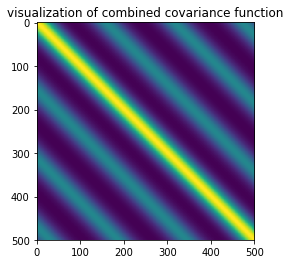

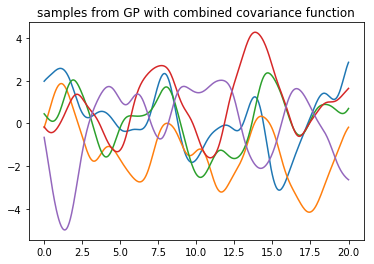

In [67]:
def comb_kernel(x1, x2, ell_1=1., alpha=1., ell_2=1.):
    K_se = squared_exponential_kernel(x1, x2, ell=ell_1, alpha=alpha)
    K_new = new_kernel(x1, x2, ell=ell_2)
    return K_se + K_new

ell_1 = 1.# Pick
ell_2 = 1.# Pick
alpha = 1.# Pick
K_comb = comb_kernel(xs, xs, ell_1=ell_1, alpha=alpha, ell_2=ell_2)
plt.imshow(K_comb)
plt.title('visualization of combined covariance function')
plt.show()

plot_samples(xs, 5, kernel_function=comb_kernel, kernel_args={'ell_1': ell_1, 'alpha': alpha, 'ell_2': ell_2})
plt.title('samples from GP with combined covariance function')
plt.show()

### Let's now look at posterior inference

We know from the lecture notes that $f(x^*) | x, f(x) \sim \mathcal{N}\left(\widetilde{m}(x^*), \widetilde{k}(x^*)\right) $

with $\widetilde{m}(x^*) = k(x^*, x)k(x,x)^{-1}f(x)$ and $\widetilde{k}(x^*) = k(x^*, x^*) - k(x^*, x)k(x,x)^{-1}k(x,x*)$.

Below, I have started implementing a function to estimate the posterior parameters. I've implemented the mean for you; add in implementation of the covariance


In [68]:
def posterior_params(x_train, y_train, x_pred, 
                     kernel=squared_exponential_kernel, keyword_args={'ell': 1., 'alpha': 1.}):
    k_train_train = kernel(x_train, x_train, **keyword_args)
    # we could make this more efficient and stable using Cholesky decompositions:
    inv_k_train_train = np.linalg.inv(k_train_train) 
    
    k_pred_train = kernel(x_pred, x_train, **keyword_args)
    
    m_post = np.dot(k_pred_train, np.dot(inv_k_train_train, y_train))
    
    k_pred_pred = kernel(x_pred, x_pred, **keyword_args)
    
    k_post = k_pred_pred - np.dot(k_pred_train, np.dot(inv_k_train_train, k_pred_train.T))
    return m_post, k_post

### Next, sample some values from the posterior, using a squared exponential kernel

We'll use our plotting values xs for x_pred.

Explore how different kernels and prior parameters effect the posterior

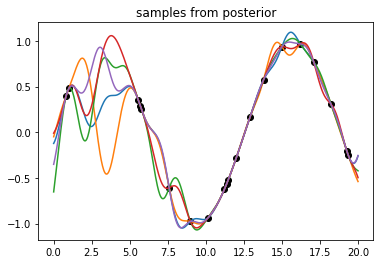

In [72]:
## pick some values for ell and alpha 

ell = 1.
alpha = 1.

# calculate posterior parameters
m_post, k_post = posterior_params(x_train=x, y_train=y, x_pred=xs, 
                     kernel=squared_exponential_kernel, keyword_args={'ell': ell, 'alpha': alpha})


# sample from the posterior
num_samples = 5
for i in range(num_samples):
    ys = np.random.multivariate_normal(mean=m_post, cov=k_post)
    plt.plot(xs,ys)
    
# Add in the actual data
plt.scatter(x, y, color='black')
plt.title('samples from posterior') 
plt.show()





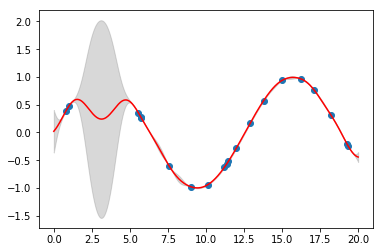

In [73]:
## We can also plot the mean plus/minus 2 standard deviations:

y_std = np.diag(k_post) # marginal standard deviations
y_upper = m_post + 1.96*y_std # 2 std dev upper bound
y_lower = m_post - 1.96*y_std


plt.fill_between(xs, y_lower, y_upper, color='grey', alpha=0.3)
plt.plot(xs, m_post, 'red')
plt.scatter(x, y)

plt.show()

### Look at the plots above. Each sampled function goes through the datapoints.

What if we don't believe we have exact samples from our function? Let's assume our data are generated according to

$$f\sim \mbox{GP}(0, \Sigma) \qquad \qquad y_i \sim \mbox{Normal}(f(x_i), \sigma^2)$$


If $\mu \sim \mbox{Normal}(\mu_0, \Sigma_0)$ and $x\sim \mbox{Normal}(\mu, \Sigma)$, then marginally, $x\sim \mbox{Normal}(\mu_0, \Sigma_0 + \Sigma)$. This means that, if we marginalize out $f$, $y$ is sampled from a Gaussian process.

* What is the kernel for the Gaussian process describing the noisy observations?
* Below, we'll generate a noisy dataset. Implement this kernel, and plot the mean and 2sd for $y^*$.


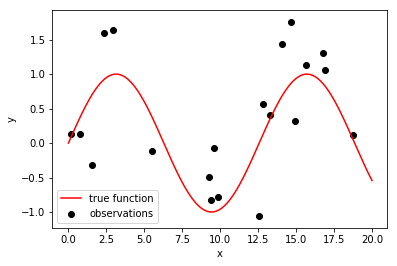

In [74]:
# generate noisy data

# First plot the function
xspace = np.linspace(0, 20, 500)
f = np.sin(xspace / 2) 
plt.plot(xspace, f, color='red', label='true function')

# sample some random locations x
N = 20

x_noisy = np.random.uniform(low=0, high=20, size=N)

# and, sample some observations
noise_sd = 0.5
y_noisy = np.sin(x_noisy / 2) + noise_sd * np.random.randn(N)
plt.scatter(x_noisy, y_noisy, color='black', label='observations')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [75]:
## implement the new kernel, based on the squared exponential kernel

def noisy_se_kernel(x1, x2, ell=1., alpha=1., noise_sd=0.5):
    k = squared_exponential_kernel(x1, x2, ell=ell, alpha=alpha)
    if len(x1) < len(x2):
        k[:, :len(x1)] += noise_sd * np.eye(len(x1))
    else:
        k[:len(x2), :] += noise_sd * np.eye(len(x2))
    return k
    
    

### Now see how it works. 

We'll use the true noise standard deviation, 0.5, here. In practice, we would optimize our parameters

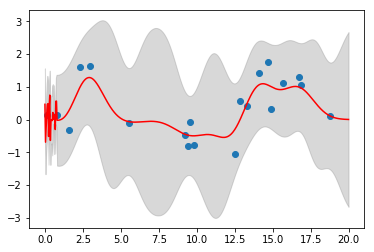

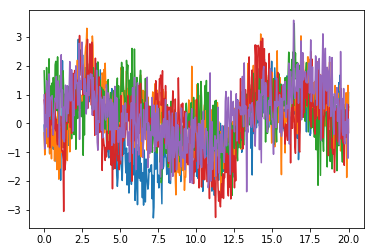

In [76]:
ell = 1.
alpha = 1.


m_post, k_post = posterior_params(x_train=x_noisy, y_train=y_noisy, x_pred=xs, 
                     kernel=noisy_se_kernel, keyword_args={'ell': ell, 'alpha': alpha, 'noise_sd': noise_sd})

## Plot the credible bounds

y_std = np.diag(k_post) # marginal standard deviations
y_upper = m_post + 1.96*y_std # 2 std dev upper bound
y_lower = m_post - 1.96*y_std


plt.fill_between(xs, y_lower, y_upper, color='grey', alpha=0.3)
plt.plot(xs, m_post, 'red')
plt.scatter(x_noisy, y_noisy)

plt.show()


## plot some samples

num_samples = 5
for i in range(num_samples):
    ys = np.random.multivariate_normal(mean=m_post, cov=k_post)
    plt.plot(xs,ys)
    
plt.show()
    

### The samples are really noisy, and the posterior variance is very wide!

This is because we are sampling from the posterior over observations $y$, rather than the function $f$.

We can also sample from the distribution over $f$. To read how to do so (and much more!) check out the resources at `http://www.gaussianprocess.org` 